In [181]:
import torch
import numpy as np 
import pandas as pd
import duckdb as duck
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
import os

In [ ]:
encoder_name = "label_encoder.pkl"
encoder_path = f"../../data/kaggle_playground/fertilizers_competition/model_assets/{encoder_name}"
SEED = 91
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [177]:
def get_encoder(dataframe: pd.DataFrame, cols):
    
    if os.path.exists(encoder_path):
        with open(encoder_path, 'rb') as f:
            le = pickle.load(f)
        print("Label Encoder Loaded")
    else:
        le = LabelEncoder()
        label_encoders = {}
        for col in cols:
            le = LabelEncoder()
            le.fit(dataframe[col])
            label_encoders[col] = le
            
        with open(encoder_path, 'wb') as f:
            pickle.dump(label_encoders, f)
        print("Label Encoder Saved")

    return le

In [178]:
df = pd.read_csv(r"../../data/kaggle_playground/fertilizers_competition/train.csv").drop(columns="id")
rename_cols = {
    'Temparature': 'temp',
    'Humidity': 'humidity',
    'Moisture':'moisture',
    'Soil Type': 'soil_type',
    'Crop Type': 'crop_type',
    'Nitrogen': 'nitrogen',
    'Potassium': 'potassium',
    'Phosphorous': 'phosphorous',
    'Fertilizer Name': 'fertilizer_name'
    }
df = df.rename(columns=rename_cols)

duck.register("df", df)
#duck.query("SELECT * FROM df")

num_cols = df.describe().columns.to_list()
cat_cols = df.drop(columns=num_cols).columns.to_list()


features = df.drop(columns="fertilizer_name").columns
target = 'fertilizer_name'

label_encoders = get_encoder(df,cols=cat_cols)

for col, le in label_encoders.items():
    df[col] = le.transform(df[col])

Label Encoder Loaded


In [158]:
label_encoders

{'soil_type': LabelEncoder(),
 'crop_type': LabelEncoder(),
 'fertilizer_name': LabelEncoder()}

## Testing model on PyTorch

In [ ]:
X = df[features]
y = df[target]

x_dim =  len(X.columns)
class_dim = len(y.unique())

X = torch.tensor(X.values, dtype=torch.float32, device=DEVICE)
y = torch.tensor(y.values, dtype=torch.long, device=DEVICE)   

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2 ,shuffle=True, random_state=SEED)

In [277]:
class Multi_Classifier(nn.Module):
    def __init__(self, in_dim, out_dim, ):
        super(Multi_Classifier, self).__init__()
        self.hidden1 = nn.Linear(in_dim, 32)
        self.hidden2 = nn.Linear(32,64)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(64, out_dim)


    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.linear(x)
        

        return x 

In [268]:
model = Multi_Classifier(in_dim=x_dim, out_dim=class_dim).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_hist = np.array([], dtype=np.int64)

best_loss = float('inf')
patience = 10
patience_counter = 0
epsilon = 1e-4  
l1_alpha = 1e-4

for epoch in range(1000):
    model.train()
    optimizer.zero_grad() 

    pred = model(X_train)
    loss = criterion(pred, y_train)
    reg_loss = 0    
  
    l1_reg = torch.tensor(0., requires_grad=True).to(DEVICE)

    for param in model.parameters():
        l1_reg = l1_reg + torch.norm(param, 1)

    loss = loss + l1_alpha * l1_reg

    loss.backward()                 
    optimizer.step()


    model.eval()
    with torch.no_grad():
        pred_test = model(X_test)
        loss_test = criterion(pred_test, y_test)
    model.train()

    loss_hist = np.append(loss_hist, loss.item())
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Loss Test: {loss_test.item():.4f}")

    if loss_test.item() < best_loss - epsilon:
        best_loss = loss_test.item()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1, Loss: 4.7000, Loss Test: 3.9658
Epoch 2, Loss: 3.9848, Loss Test: 3.3710
Epoch 3, Loss: 3.3909, Loss Test: 2.9482
Epoch 4, Loss: 2.9688, Loss Test: 2.7010
Epoch 5, Loss: 2.7224, Loss Test: 2.5698
Epoch 6, Loss: 2.5919, Loss Test: 2.4891
Epoch 7, Loss: 2.5118, Loss Test: 2.4251
Epoch 8, Loss: 2.4482, Loss Test: 2.3663
Epoch 9, Loss: 2.3897, Loss Test: 2.3109
Epoch 10, Loss: 2.3345, Loss Test: 2.2599
Epoch 11, Loss: 2.2837, Loss Test: 2.2150
Epoch 12, Loss: 2.2389, Loss Test: 2.1779
Epoch 13, Loss: 2.2019, Loss Test: 2.1502
Epoch 14, Loss: 2.1743, Loss Test: 2.1337
Epoch 15, Loss: 2.1578, Loss Test: 2.1292
Epoch 16, Loss: 2.1533, Loss Test: 2.1349
Epoch 17, Loss: 2.1590, Loss Test: 2.1449
Epoch 18, Loss: 2.1689, Loss Test: 2.1518
Epoch 19, Loss: 2.1757, Loss Test: 2.1502
Epoch 20, Loss: 2.1741, Loss Test: 2.1389
Epoch 21, Loss: 2.1626, Loss Test: 2.1199
Epoch 22, Loss: 2.1434, Loss Test: 2.0970
Epoch 23, Loss: 2.1203, Loss Test: 2.0740
Epoch 24, Loss: 2.0970, Loss Test: 2.0535
E

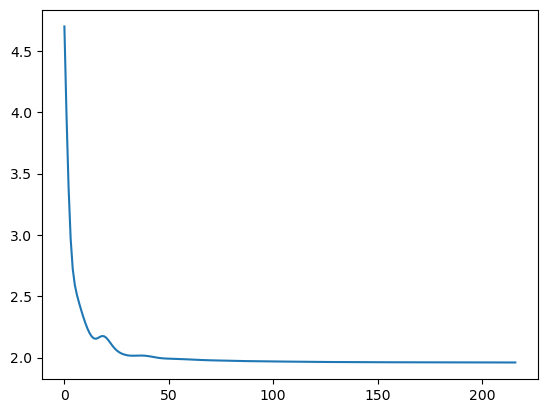

In [270]:
plt.plot(loss_hist)

In [273]:
model.eval()

out = model(X_test)
_, pred = torch.max(out,dim=1)
pred = label_encoders['fertilizer_name'].inverse_transform(pred.cpu().numpy())
actual = label_encoders['fertilizer_name'].inverse_transform(y_test.cpu().numpy())

pred_df = pd.DataFrame({'actual':actual,'pred': pred})

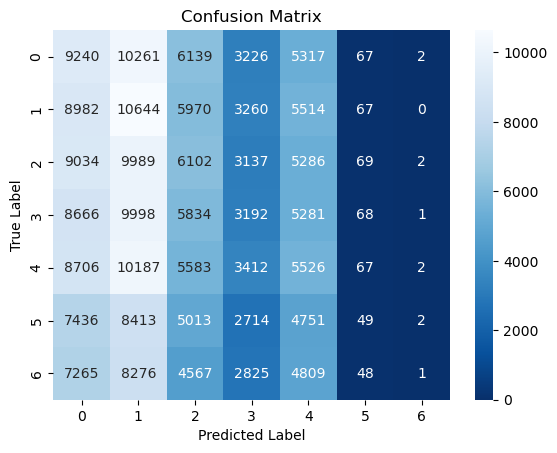

In [274]:
cm = confusion_matrix(pred_df['actual'],pred_df['pred'])
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues_r")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()